In [1]:
import re
import os
import pickle
import numpy as np
import multiprocessing

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from utils import *

cores = multiprocessing.cpu_count()
elmo_module="module/elmo3"
sent_module="module/sent_encoder4"

In [2]:
STEM=True
LEMM=not STEM

In [3]:
#tf.compat.v1.disable_eager_execution()
elmo = hub.Module(elmo_module, trainable=False)

### PreProcessing functions

In [4]:
codelist = ['\r', '\n', '\t']
def parse_doc(text: str) -> str:
    text = text.lower()
    # no & references
    text = re.sub(r'&(.)+', "", text) 
    # replace pct abreviation
    text = re.sub(r'pct', 'percent', text) 
    # no non-ASCII strings
    text = re.sub(r'[^\x00-\x7f]',r'', text) 
    # omit words that are all digits
    if text.isdigit():  
        text = ""  
    # get rid of escape codes
    for code in codelist: 
        text = re.sub(code, ' ', text) 
    text = re.sub('\s+', ' ', text) # replace multiple spacess with one space
    return text

def parse_words(text: str)-> str:
    # split document into individual words
    tokens=text.split()
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out tokens that are one or two characters long
    tokens = [word for word in tokens if len(word) > 2]
    # filter out tokens that are more than twenty characters long
    tokens = [word for word in tokens if len(word) < 21]
    # perform word stemming if requested
    if STEM:
        ps = PorterStemmer()
        tokens = [ps.stem(word) for word in tokens]
    if LEMM:
        lemm = WordNetLemmatizer()
        tokens = [lemm.lemmatize(word) for word in tokens]
    # recreate the document string from parsed words
    text = ''
    for token in tokens:
        text = text + ' ' + token
    return text

def text_process(text: str)-> str:
    doc = parse_doc(text)
    return parse_words(doc)

In [5]:
SELECT_CATEGORY='RECREATION'
categories = ['rec.autos',
        'rec.motorcycles',
        'rec.sport.baseball',
        'rec.sport.hockey']

### Parse train & test

In [6]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                    remove=('headers', 'footers', 'quotes'),
                                    categories=categories)

with multiprocessing.Pool(cores) as p:
    X_train = np.asarray(p.map(text_process, 
                               newsgroups_train.data)
                        )
    X_test = np.asarray(p.map(text_process, 
                              newsgroups_test.data)
                       )
y_train = newsgroups_train.target
y_test = newsgroups_test.target
#del newsgroups_train
#del newsgroups_test
del X_train
del X_test

### ELMO embedding scripts

In [7]:
def elmo_vectors(x: np.ndarray):
    embeddings = elmo(x, 
                      signature="default", 
                      as_dict=True)["default"]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        # return average of ELMo features
        return sess.run(embeddings)
    
def elmo_iter_train(x: np.ndarray):
    list_train = [x[i:i+5] for i in range(0,x.shape[0],5)]
    return np.concatenate([elmo_vectors(x) for x in list_train],
                          axis = 0)

### <font color=red>CAUTION</font> before running the below cell
I have pickled the below processes, you don't need to run them. 

If you do, it can run out of your memory OR it will take a long time to process all data.

In [8]:
'''
increment=60
for batch in range(0,X_train.shape[0],increment):
    if batch >= 1860:
        elmo_tmp = elmo_iter_train(X_train[batch:batch+increment])
        pickle.dump( elmo_tmp, open( "elmo20newsgroup/train/elmo_RECREATION_train%d.pickle" % batch, "wb" ) )
'''

'\nincrement=60\nfor batch in range(0,X_train.shape[0],increment):\n    if batch >= 1860:\n        elmo_tmp = elmo_iter_train(X_train[batch:batch+increment])\n        pickle.dump( elmo_tmp, open( "elmo20newsgroup/train/elmo_RECREATION_train%d.pickle" % batch, "wb" ) )\n'

### 20newsgroups' `RECREATION` data shape:
* X_train: (2389, )
* X_test:  (1590,)

There are 4 sub-categories: 
* 'rec.autos',
* 'rec.motorcycles',
* 'rec.sport.baseball',
* 'rec.sport.hockey'

Because I have pickled all the pre-processed and embeddings, all the prior cells can be ignored, I will map the pickles directly to variables

### read ELMO pickle script

In [9]:
def read_elmo_vect(path):
    def extract_number(string):
        r = re.compile(r'(\d+)')
        return int(r.findall(string)[0])
    sortedFiles = sorted(os.listdir(path),
                         key=lambda x: extract_number(x) )
    result = pickle.load( open(path+ sortedFiles[0], "rb" ) )
    for f in sortedFiles[1:]:
        result = np.concatenate([pickle.load( open(path+ f, "rb" ) ),
                                result],
                              axis = 0)
    return result

In [10]:
X_train = read_elmo_vect('elmo20newsgroup/train/')
X_test = read_elmo_vect('elmo20newsgroup/test/')

In [11]:
X_test.shape

(1590, 1024)

In [12]:
from sklearn.manifold import TSNE
randIndx=np.random.randint(0, len(X_test), 100)
X = X_test[randIndx]
Y = y_test[randIndx]

tsne = TSNE(n_components=2, metric="euclidean", random_state=128)
X = tsne.fit_transform(X)

In [13]:
k=len(categories)
kmeans = KMeans(n_clusters=k, random_state=128).fit(X_train)

### Visualization

For n_clusters = 4 The average silhouette_score is : 0.34265795


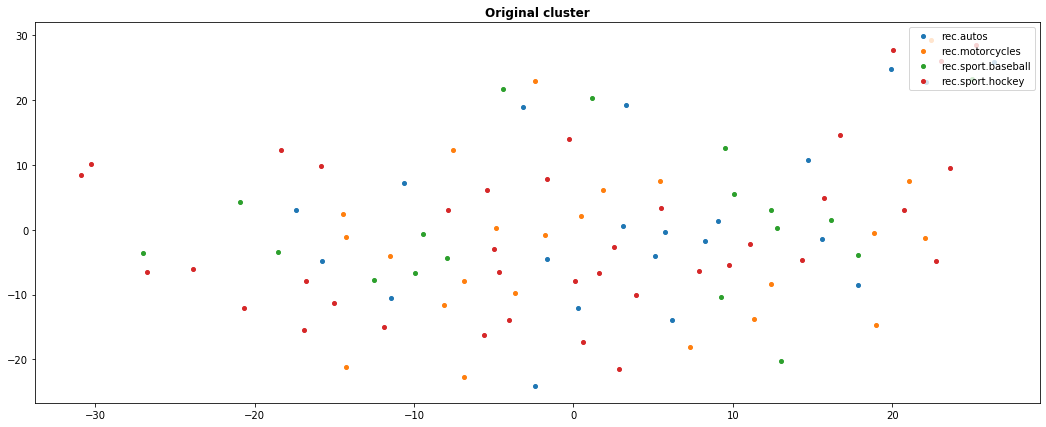

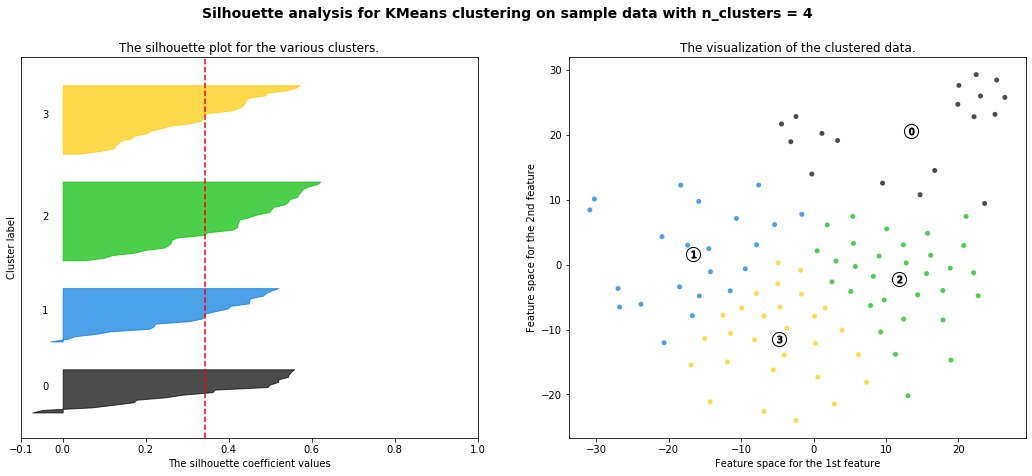

In [14]:
plot_default_cluster(X, Y, newsgroups_test.target_names)
kmeans_silhouette_analysis(kmeans, k, X)